In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC
from typing import Self
from logging import getLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.exceptions import NotFittedError
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [133]:
class Config:
    DATA_FOLDER = f"../data"
    ANALYSIS_FOLDER = f"../analysis"
    TRAIN_FILE = "train.csv"
    TEST_FILE = "test.csv"
    FEATURES_SUBSETS = {
        "mome": "Moments",
    }


class BaseWrapper(ABC):
    TARGET = "Class"
    
    def __init__(self, class_name):
        self.config = Config()
        self.logger = getLogger(class_name)

    def _map_features_subset(self, features_subset: str):
        if features_subset in self.config.FEATURES_SUBSETS.values():
            return features_subset
        if features_subset in self.config.FEATURES_SUBSETS.keys():
            return self.config.FEATURES_SUBSETS[features_subset]
        self.logger.exception(
            f"features_subset must be in {self.config.FEATURES_SUBSETS.values()} or {self.config.FEATURES_SUBSETS.keys()}"
        )
        raise ValueError


class DataLoader(BaseWrapper):
    """Wrapper for loading data"""

    def __init__(self):
        super().__init__(__name__)

    def load(self, features_subset: str):
        features_subset = self._map_features_subset(features_subset)
        return self._name_dataframes(
            *self._split_features_labels(
                *self._load_train_test(features_subset)
            ),
            features_subset
        )

    def _load_train_test(
        self, features_subset: str
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
        folder = f"{self.config.DATA_FOLDER}/{features_subset}"
        return (
            pd.read_csv(
            f"{folder}/{self.config.TRAIN_FILE}", index_col=[0]
        ), 
            pd.read_csv(
            f"{folder}/{self.config.TEST_FILE}", index_col=[0]
        )
        )

    def _split_features_labels(
        self, train: pd.DataFrame, test: pd.DataFrame
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        X_train, y_train = (
            train.drop(self.TARGET, axis=1), train[self.TARGET]
        )
        X_test, y_test = (
            (test.drop(self.TARGET, axis=1), test[self.TARGET])
            if self.TARGET in test.columns
            else (test, None)
        )
        return X_train, X_test, y_train, y_test

    def _name_dataframes(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
        features_subset: str,
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        dfs = (X_train, X_test, y_train, y_test)
        for df in dfs:
            if df is not None:
                df.attrs["name"] = features_subset
        return dfs
    
class DataAnalyzer(BaseWrapper):
    def __init__(self, X_train, y_train):
        super().__init__(__name__)
        self._data = pd.concat([X_train, y_train], axis=1)
        self._data.attrs["name"] = X_train.attrs["name"]
      
    def __str__(self):
        return str(self._data)
    
    def analyze(self):
        self.data_info()
        self.data_summary()
        if len(self._data.drop(self.TARGET, axis=1).columns) <= 25:
            self.correlogram()
            self.features_histograms()
            self.target_feature_scatterplots()
        
    def data_info(self):
        print(self._data.info(verbose=True))
        
    def data_summary(self):
        print(self._data.describe())
      
    def correlogram(self):
        annot = len(self._data.drop(self.TARGET, axis=1).columns) <= 6
        sns.heatmap(self._data.corr("pearson"), cmap="inferno", annot=annot)
        plt.title(f"{self._data.attrs["name"]} Correlogram", fontsize=22)
        plt.show()
        
    def features_histograms(self):
        feature_cols = self._data.drop(self.TARGET, axis=1).columns
        size = int(np.ceil(np.sqrt(len(feature_cols))))
        fig, axs = plt.subplots(nrows=size, ncols=size, figsize=(20,18))
        for i in range(size):
            for j in range(size):
                col_pos = i * size + j
                if col_pos >= len(feature_cols):
                    break
                feature = feature_cols[col_pos]
                axs[i, j].hist(self._data[feature])
                axs[i, j].set_xlabel(f"{feature} Value", fontsize=10)
                axs[i, j].set_ylabel("Count", fontsize=10)
        plt.suptitle(f"{self._data.attrs["name"]} Features Histograms", fontsize=22)
        plt.show()
        
    def target_feature_scatterplots(self):
        feature_cols = self._data.drop(self.TARGET, axis=1).columns
        size = int(np.ceil(np.sqrt(len(feature_cols))))
        fig, axs = plt.subplots(nrows=size, ncols=size, figsize=(20,18))
        for i in range(size):
            for j in range(size):
                col_pos = i * size + j
                if col_pos >= len(feature_cols):
                    break
                feature = feature_cols[col_pos]
                axs[i, j].scatter(x=self._data[feature], y=self._data[self.TARGET])
                axs[i, j].set_xlabel(f"{feature} Value", fontsize=10)
                axs[i, j].set_ylabel(f"{self.TARGET}", fontsize=10)
        plt.suptitle(f"{self._data.attrs["name"]} Target-Feature Scatterplots", fontsize=22)
        plt.show()
        
class DataPipeline(BaseWrapper):
    
    CONTINUOUS_TYPES = set([np.float64])
    DISCRETE_TYPES = set([np.int64])
    
    def __init__(self):
        self._feature_selector = VarianceThreshold(threshold=0.0)
        self._imputer = make_column_transformer(
            (SimpleImputer(strategy="mean"),
             make_column_selector(dtype_include=self.CONTINUOUS_TYPES)),
            (SimpleImputer(strategy="most_frequent"),
             make_column_selector(dtype_include=self.DISCRETE_TYPES))
        )
        self._scaler = MinMaxScaler()
        self._fitted = False
    
    def fit(self, X_train: pd.DataFrame) -> Self:
        self._feature_selector.fit(X_train)
        X_train_selected = pd.DataFrame(self._feature_selector.transform(X_train), \
                            columns=self._feature_selector.get_feature_names_out(X_train.columns))
        self._imputer.fit(X_train_selected)
        self._scaler.fit(X_train_selected)
        self._fitted = True
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self._fitted:
            X = pd.DataFrame(self._feature_selector.transform(X), \
                            columns=self._feature_selector.get_feature_names_out(X.columns))
            X = pd.DataFrame(self._imputer.transform(X), columns=X.columns)
            X = pd.DataFrame(self._scaler.transform(X), columns=X.columns)
            return X
        raise NotFittedError
    
    def fit_transform(self, X_train: pd.DataFrame) -> pd.DataFrame:
        self.fit(X_train)
        return self.transform(X_train)
    
class KMeansEvaluation:
    METRICS = ["Silhueta", "ARI"]
    
    @staticmethod
    def elbow_method(X: pd.DataFrame, pipeline: DataPipeline, random_state=0):
        X_preprocessed = pipeline.fit_transform(X)
        wcss = {}
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=random_state).fit(X_preprocessed)
            wcss[k] = kmeans.inertia_
        plt.figure()
        plt.plot(list(wcss.keys()), list(wcss.values()), marker="o")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
        plt.show()
        
    @classmethod
    def scores(cls, X: pd.DataFrame, y: pd.DataFrame, pipeline: DataPipeline, random_state=0):
        X_preprocessed = pipeline.fit_transform(X)
        cols = cls.METRICS
        print("Running model:")
        model = KMeans(n_clusters=2, random_state=random_state)
        print(model)
        labels = model.fit_predict(X_preprocessed)
        internal = silhouette_score(X_preprocessed, labels)
        external = adjusted_rand_score(y, labels)
        scores = pd.DataFrame(data=np.array([[internal, external]]), index=["k-means (k=2)"], columns=cols)
        scores.index.name = "Métrica de integração"
        return scores
        
class HierarchicalClusteringEvaluation:    
    LINKAGES = ["single", "average", "complete"]
    METRICS = ["Silhueta", "ARI"]
    
    @classmethod
    def scores(cls, X: pd.DataFrame, y: pd.DataFrame, pipeline: DataPipeline):
        X_preprocessed = pipeline.fit_transform(X)
        cols = cls.METRICS
        scores = None
        models = cls._get_models()
        print("Running models:")
        for i in range(len(models)):
            model = models[i]
            print(model)
            labels = model.fit_predict(X_preprocessed)
            internal = silhouette_score(X_preprocessed, labels)
            external = adjusted_rand_score(y, labels)
            row = pd.DataFrame(data=np.array([[internal, external]]), index=[f"{cls.LINKAGES[i]}-linkage"], columns=cols)
            if scores is None:
                scores = row
            else:
                scores = pd.concat([scores, row], axis=0)
        scores.index.name = "Métrica de integração"
        return scores
            
    @classmethod
    def _get_models(cls):
        return [AgglomerativeClustering(n_clusters=2, 
                                        metric="euclidean", 
                                        linkage=linkage)
                for linkage in cls.LINKAGES]
    

In [134]:
loader = DataLoader()
data = {}
subset = "mome"
X_train, _, y_train, _ = loader.load(subset)

## K-Means - Elbow Method

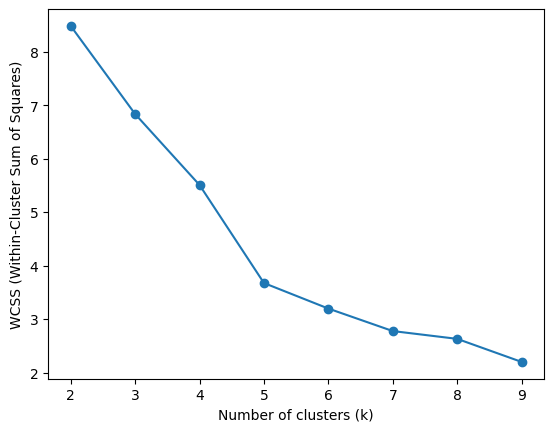

Running model:
KMeans(n_clusters=2, random_state=0)



,Silhueta,ARI
Métrica de integração,,
k-means (k=2),0.418101,0.103556


In [135]:
KMeansEvaluation.elbow_method(X_train, DataPipeline(), random_state=0)
kmeans_scores = KMeansEvaluation.scores(X_train, y_train, DataPipeline(), random_state=0)
print("")
kmeans_scores

## Hierarchical Clustering

In [136]:
hc_scores = HierarchicalClusteringEvaluation.scores(X_train, y_train, DataPipeline())
print("")
hc_scores

Running models:
AgglomerativeClustering(linkage='single')
AgglomerativeClustering(linkage='average')
AgglomerativeClustering(linkage='complete')



,Silhueta,ARI
Métrica de integração,,
single-linkage,0.432004,-0.012882
average-linkage,0.432004,-0.012882
complete-linkage,0.404715,0.125988


## Resultados Unidos

In [137]:
results = pd.concat([kmeans_scores, hc_scores], axis=0)
results

,Silhueta,ARI
Métrica de integração,,
k-means (k=2),0.418101,0.103556
single-linkage,0.432004,-0.012882
average-linkage,0.432004,-0.012882
complete-linkage,0.404715,0.125988
